# Quantum fast-forwarding implementation in Qiskit

## Panagiotis Theodorakopoulos

The code is written for a specific version of Qiskit. In order to run the code, download the necessery libraries appear on the first cell.

In [2]:
import numpy as np
import scipy.linalg
import math
from math import pi, gcd

# ! python -m pip install matplotlib pylatexenc
# ! python -m pip install qiskit==0.44.3
# ! python -m pip install PyDTMC

from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import *
from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator
from matplotlib.pyplot import plot,show,hist,savefig
from pydtmc import MarkovChain
from scipy.special import binom

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [3]:
def closest_unitary(A):
    """ Calculate the unitary matrix U that is closest with respect to the
        operator norm distance to the general matrix A.

        Return U as a numpy matrix.
    """
    V, __, Wh = scipy.linalg.svd(A)
    U = np.matrix(V.dot(Wh))
    return U

In [4]:
def create_path_graph(n):
    """ Create a Markov Chain, corresponding to a path graph of size n.
        
        Return transition_matrix as a numpy matrix.
    """
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                continue  
            elif abs(i-j) == 1:
                transition_matrix[i, j] = 0.25  
    for i in range(n):
        transition_matrix[i, i] = 1 - np.sum(transition_matrix[i, :])

    return transition_matrix



In [5]:
def create_ring_topology(size):
    """ Create a Markov Chain, corresponding to ring topology graph of size n.
        
        Return transition_matrix as a numpy matrix.
    """
    transition_matrix = np.zeros((size, size))
    
    for i in range(size):
        transition_matrix[i, (i + 1) % size] = 0.1
        transition_matrix[i, (i - 1) % size] = 0.1
        transition_matrix[i, i] = 0.8
    
    equilibrium_distribution = np.ones(size) / size
    for i in range(size):
        for j in range(size):
            transition_matrix[i, j] *= equilibrium_distribution[j]
    
    transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)
    
    return transition_matrix

In [6]:
def create_fully_connected_graph(size):
    """ Create a Markov Chain, corresponding to a fully connected graph graph of size n.

        Return transition_matrix as a numpy matrix.
    """
    matrix = np.random.rand(size, size)
    reversible_matrix = (matrix + matrix.T) / 2
    reversible_matrix /= reversible_matrix.sum(axis=1)[:, np.newaxis]
    return reversible_matrix

In [7]:


size = int(input("Enter the size of the Markov chain: "))
while True:
    type_of_chain = int(input("Choose the topology of the Markov chain, \
for path graph topology with self loops enter 1, \
for bidirectional ring topology with self loops enter 2, for fully connected graph enter 3: "))

    if type_of_chain == 1:
        P = create_path_graph(size)
        break  
    elif type_of_chain == 2:
        P = create_ring_topology(size)
        break  
    elif type_of_chain == 3:
        P = create_fully_connected_graph(size)
        break  
    else:
        print('Enter a valid choice')

mc = MarkovChain(P)
print(mc)


DISCRETE-TIME MARKOV CHAIN
 SIZE:           5
 RANK:           5
 CLASSES:        1
  > RECURRENT:   1
  > TRANSIENT:   0
 ERGODIC:        YES
  > APERIODIC:   YES
  > IRREDUCIBLE: YES
 ABSORBING:      NO
 MONOTONE:       NO
 REGULAR:        YES
 REVERSIBLE:     YES
 SYMMETRIC:      YES



In [8]:

def calculate_epsilon_prime_and_taf(D, v, t, epsilon):
    """ Calculate epsilon prime, for the LCU method.

        Return epsilon prime.
    """

    D_t_v = np.linalg.matrix_power(D, t) @ v
    norm_D_t_v = np.linalg.norm(D_t_v)
    epsilon_prime = norm_D_t_v * epsilon / 2
    
    return epsilon_prime

def calculate_ql(t, epsilon_prime):
    """ Calculate the coefficients ql, for the LCU method.

        Return ql as a numpy vector.
    """

    taf = int(math.ceil(np.sqrt(2 * t * np.log(2 / epsilon_prime))))
    ql = np.zeros(taf + 1)

    for l in range(taf + 1):
        if l > 0 and (t - l) % 2 == 0:
            ql[l] = 1 / 2**(t - 1) * binom(t, (t - l) // 2)
        elif l == 0 and t % 2 == 0:
            ql[l] = 1 / 2**t * binom(t, t // 2)
    return ql, taf




### Choose the desired error $\varepsilon$, and the steps you want to simulate.

In [9]:
v = np.zeros(len(P))
v[0] = 1 
steps = int(input("Enter the number of steps you want to simulate: "))
epsilon = 0.5
D = np.sqrt(np.multiply(P,P.T))
epsilon_prime = calculate_epsilon_prime_and_taf(D, v, steps, epsilon)

ql, taf = calculate_ql(steps, epsilon_prime)

print("Epsilon':", epsilon_prime)
print("Taf:", taf)
gate_powers = []
for i in range(len(ql)):
    if ql[i]>0:
        gate_powers.append(i)

linear_qubits = int(np.ceil(np.log2(taf)))
print("Number of qubits for the LCU method:", linear_qubits)

Epsilon': 0.11275772535430847
Taf: 10
Number of qubits for the LCU method: 4


In [10]:
enlarged_matrix_len = len(P)+1
enlarged_matrix_size = len(P)*(len(P)+1)

In [11]:

def number_of_required_qubits(n):
    """ Calculate the number of required qubits for W operator.

        Return upper_exp.
    """
    log2_n = math.log(n, 2)
    upper_exp = math.ceil(log2_n)
    return upper_exp

closest_exp = number_of_required_qubits(enlarged_matrix_size)
print(f"The number of required qubits for W operator is {closest_exp}.")


The number of required qubits for W operator is 5.


In [12]:
def create_V_q(q_values,n):
    """ Create Vq matrix.

        Return V_q as a numpy matrix.
    """
    V_q = np.zeros((n,n))
    for i in range(len(q_values)):
            if q_values[i]>0:
                V_q[i,0] = np.sqrt(q_values[i])        
    return V_q

n = 2**(linear_qubits)
pre_V_q = create_V_q(ql,n)
V_q_matrix = closest_unitary(pre_V_q)

In [13]:
def construct_n_matrices(P):
    """ Create the non zero blocks, of the diagonal block matrix representation of the V operator.

        Return matrices as a list of numpy matrices.
    """
    n = P.shape[0] 
    matrices = [] 
    for k in range(n):
        matrix = np.zeros((n+1, n+1))
        for i in range(n):
            matrix[i+1, 0] = np.sqrt(P[k, (i+k) % n ])

        matrices.append(matrix)    
    return matrices

matrices = construct_n_matrices(P)
unitary_matrices = [closest_unitary(matrix) for matrix in matrices]

In [14]:
def create_block_diagonal_with_matrices(matrices):
    """ Create the block diagonal matrix representation of the V operator.

        Return block_diagonal_matrix as a numpy matrix.
    """
    n = len(matrices)
    total_size =(n+1)
    dim = matrices[0].shape[0]
    D = np.zeros_like(matrices[0]) 
    iden = np.eye((n+1))
    block_structure = []
    for i in range(total_size):
        row_blocks = []
        for j in range(total_size):            
            if i == j and i < n : 
                    row_blocks.append(matrices[i])
            elif i == j and i >= n :
                row_blocks.append(iden)
            else:  
                row_blocks.append(D)
        block_structure.append(row_blocks)
    block_diagonal_matrix = np.block(block_structure)    
    return block_diagonal_matrix

pre_V_matrix = create_block_diagonal_with_matrices(unitary_matrices[:])

In [15]:
def expand_matrix(pre_v, new_size):
    """ Expand the diagonal block matrix representation of the V operator if it has smaller size than needed,
        in order to match Qiskit's expectations for Unitary gates.

        Return expanded_matrix as a numpy matrix.
    """
    expanded_matrix = np.zeros((new_size, new_size))
    pre_v_size = pre_v.shape[0]
    expanded_matrix[:pre_v_size, :pre_v_size] = pre_v
    np.fill_diagonal(expanded_matrix[pre_v_size:, pre_v_size:], 1)
    
    return expanded_matrix

def reduce_matrix(matrix, new_size):
    """ Reduce the diagonal block matrix representation of the V operator if it has greater size than needed,
        in order to match Qiskit's expectations for Unitary gates.

        Return reduced_matrix as a numpy matrix.
    """
    reduced_matrix = matrix[:new_size, :new_size]   
    return reduced_matrix

new_size = 2**(closest_exp)  
if len(pre_V_matrix) < new_size:
    V_matrix = expand_matrix(pre_V_matrix, new_size)
elif len(pre_V_matrix) > new_size:
    V_matrix = reduce_matrix(pre_V_matrix, new_size)
else:    
    V_matrix = pre_V_matrix

In [16]:
def generate_custom_sequence(n):
    """ Generate the required sequence in order to construct the matrix representation of
        SHIFT operator.

        Return result as a numpy list.
    """
    sequence = list(range(1, n*(n+1) + 1))
    result = []
    i = 2    
    while i < len(sequence):
        for _ in range(n-1):
            if i < len(sequence):
                result.append(sequence[i])
                i += 1
        i += 2    
    return result

result_sequence = generate_custom_sequence(len(P))

In [17]:
def pair_elements_with_modification(sequence, n):
    """ Pair the elements of the required sequence, in order to construct the matrix representation of
        SHIFT operator.
        
        Return pairs as a list of tuples.
    """
    group_size = n - 1
    num_groups = len(sequence) // group_size
    groups = [sequence[i*group_size:(i+1)*group_size] for i in range(num_groups)]
    pairs = []

    for j in range(num_groups - 1):  
        for i in range(len(groups[j])-j):
                pair_element_index = group_size - 1 - i 
                pairs.append((groups[j][i], groups[i+1+j][pair_element_index]))    
    return pairs

modified_pairs = pair_elements_with_modification(result_sequence, len(P))

In [18]:
def create_shift_matrix(n, modified_pairs, result_sequence):
    """ Create the matrix representation of
        SHIFT operator.
        
        Return shift_matrix as a numpy matrix.
    """
    
    shift_matrix = np.zeros((2**(n), 2**(n)))
    result_sequence = [x - 1 for x in result_sequence]

    for i in range(len(modified_pairs)):
        shift_matrix[modified_pairs[i][0]-1][modified_pairs[i][1]-1] = 1
        shift_matrix[modified_pairs[i][1]-1][modified_pairs[i][0]-1] = 1
    for i in range((2**(n))):
        if i not in (result_sequence):
            shift_matrix[i, i] = 1

    return shift_matrix


shift_matrix = create_shift_matrix(closest_exp, modified_pairs, result_sequence)

In [19]:
def create_diagonal_matrix(N, limit, states):
    """ Create the matrix representation of projector on the flat subspace.
        
        Return matrix as a numpy matrix.
    """
    size = 2 ** N
    matrix = np.zeros((size, size))
    number_of_states = []
    for i in range(0, size - limit, limit):
        number_of_states.append(i)
        if i < size and len(number_of_states) <= states: 
            matrix[i, i] = 1
    return matrix
states = len(P)
Prb = create_diagonal_matrix(closest_exp, enlarged_matrix_len, states)

In [20]:
def create_reflection(Prb):
    """ Create the matrix representation of the reflection.
        
        Return reflection as a numpy matrix.
    """
    reflection = 2*Prb - np.identity(len(Prb))
    return reflection

reflection = create_reflection(Prb)

### In the next cell, the corresponding states of the flat subspace are identified.

In [21]:
flat_space = []
diagonal_elements = np.diag(Prb)  
total_circuit_size = closest_exp + linear_qubits
for i, value in enumerate(diagonal_elements):
    if value == 1:
        flat_space.append(i)
        
flat_space_binary = [bin(x)[2:] for x in flat_space]  
flat_space_binary_padded = [x.zfill(total_circuit_size) for x in flat_space_binary]
i=1
for binary_rep in flat_space_binary_padded:
    print(f"|{i},b> -> |{binary_rep}>") 
    i+=1

|1,b> -> |000000000>
|2,b> -> |000000110>
|3,b> -> |000001100>
|4,b> -> |000010010>
|5,b> -> |000011000>


In [22]:
def generate_binary_numbers_little_endian(n):
    """ Create the binary sequence needed to construct the controlled W operators, using little endian notation.
        
        Return control_states as a numpy list.
    """
    control_states = []
    for i in n:
        binary_little_endian = bin(i)[2:][::-1]
        control_states.append(binary_little_endian)
    return control_states

control_states = generate_binary_numbers_little_endian(gate_powers)
control_states = [x + '0' * (linear_qubits - len(x)) for x in control_states]


### In the next cells we create the Unitary gates $V_q, V_q^\dagger, reflection, V, V^\dagger \text{and } SHIFT$.

In [23]:
V_q = UnitaryGate(Operator(V_q_matrix), label = 'V_q')
V_q_dagger = UnitaryGate(Operator(V_q_matrix.T), label = 'V_q_dagger')


In [39]:
#Uncomment the following lines to create the Unitary gates for the V, reflection and SHIFT operators
# ref = UnitaryGate(Operator(reflection), label = 'ref')
# S = UnitaryGate(Operator(shift_matrix), label = 'Shift')
# V = UnitaryGate(Operator(V_matrix), label = 'V')
# V_dagger = V_matrix.T
# V_dagger = UnitaryGate(Operator(V_dagger), label = 'V_dagger')

### In the next cell the qubit order in which the Unitary gates will be applied on is computed, as well as the total number of qubits for the W operator and the LCU method.

In [25]:
n_qubits = total_circuit_size
last_qubits = list(range(n_qubits))[-linear_qubits:]
first_qubits = list(range(n_qubits))[:-linear_qubits]
control_qubits = list(reversed(last_qubits))
qubit_order = list(control_qubits + first_qubits)
n_qubits_w = total_circuit_size - linear_qubits

### Construct the circuit for the quantum walk operator W or construct directly the quantum walk operator W by its building blocks. The latter method is less time consuming.

In [36]:
V_shift = np.dot(shift_matrix,V_matrix)
V_shift_V_d = np.dot(V_matrix.T,V_shift)
U_ref = np.dot(reflection,V_shift_V_d)
W_gate = UnitaryGate(Operator(U_ref), label = 'W')

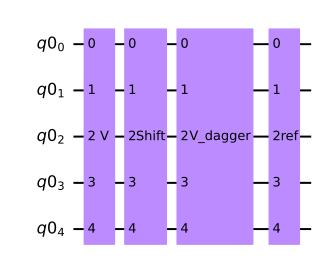

In [26]:
# q = QuantumRegister(n_qubits_w)
# W = QuantumCircuit(q,name="W")

# W.append(V, first_qubits)
# W.append(S, first_qubits)
# W.append(V_dagger, first_qubits)
# W.append(ref, first_qubits)
# W_gate = W.to_gate()
# W.draw(output = 'mpl')

### Construct the controlled Unitary gates of the quantum walk operator W.

In [27]:
cW_gates = []

for i, ctrl_state in zip(gate_powers, control_states):
    temp_gate = W_gate.power(i).control(linear_qubits)
    temp_gate.ctrl_state = ctrl_state
    cW_gates.append(temp_gate)
    print(f"Gate power {i} completed")



Gate power 0 completed
Gate power 2 completed
Gate power 4 completed
Gate power 6 completed
Gate power 8 completed
Gate power 10 completed


### Construct the circuit for the LCU method. In order to start the walk from other than the first node, add the appropriate X-Gates to construct the desired initial state of the flat subspace, as identified previously. 
##### (Do not forget to change the initial position in the classical case also.)

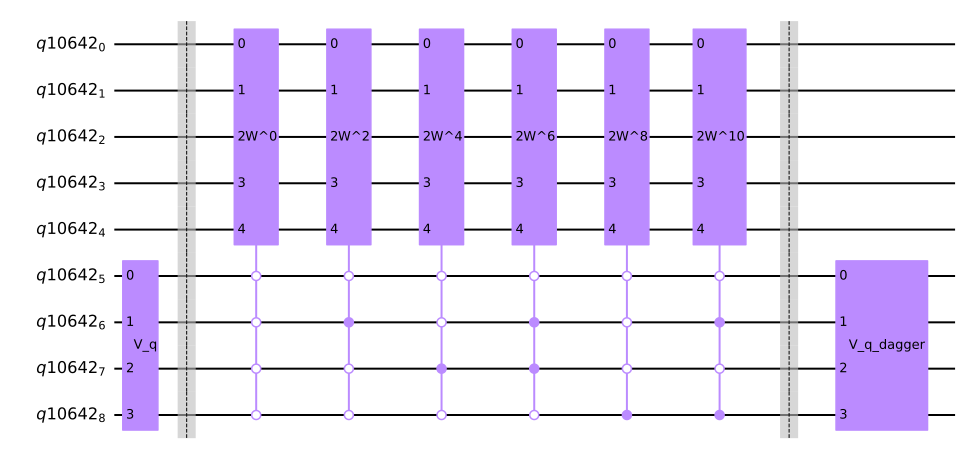

In [37]:
q = QuantumRegister(n_qubits)
qc = QuantumCircuit(q)

qc.append(V_q, last_qubits)
qc.barrier()
for gate in cW_gates:
    qc.append(gate, qubit_order)

qc.barrier()
qc.append(V_q_dagger, last_qubits)

qc.draw(output = 'mpl')

### Perform the classical random walk.

In [32]:

def classically(steps, D, classical_vector):
    """ Perform the random walk classicaly.
        
    """
    
    for step in range(1, steps + 1):
        classical_vector =  np.array(np.dot(classical_vector,D))
        classical_vector =  np.squeeze(classical_vector)
        
        print(f'STEP Discriminant {step}')
        print(classical_vector)



classical_vector = np.zeros(len(P))
classical_vector[0] = 1
D = np.sqrt(np.multiply(P,P.T))
# Uncomment the line bellow if you want to see the intermediate or next steps of the walk.
# classically(25, D, classical_vector)
classical_walk = np.dot(np.linalg.matrix_power(D,steps),classical_vector)
print(f"The classical result with {steps} steps is: {classical_walk}")

The classical result with 16 steps is: [0.23733612 0.21119882 0.17013312 0.17013312 0.21119882]


### Run the statevector simulator and output the real part of the coefficients of the basis vectors corresponding to the flat states.

In [29]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
job_result = job.result()
statevector = job_result.get_statevector(qc)
i=1
for binary_rep,flat in zip(flat_space_binary_padded,flat_space):
    real_part = statevector[flat].real
    print(f"|{i},b> -> |{binary_rep}>, Probability of being on node {i}: {real_part}") 
    i+=1

|1,b> -> |000000000>, Probability of being on node 1: 0.23641137329573347
|2,b> -> |000000110>, Probability of being on node 2: 0.21040621255285177
|3,b> -> |000001100>, Probability of being on node 3: 0.17138810093235787
|4,b> -> |000010010>, Probability of being on node 4: 0.17138810093231938
|5,b> -> |000011000>, Probability of being on node 5: 0.21040621255259062


### Compare the classical random walk and the simulation.

In [31]:
i=1
for binary_rep,flat in zip(flat_space_binary_padded,flat_space):
    real_part = statevector[flat].real
    print(f"|{i},b> -> |{binary_rep}>, Quantum walk node {i}: {real_part}, Classical walk node {i}: {classical_walk[i-1]}") 
    i+=1

|1,b> -> |000000000>, Quantum walk node 1: 0.23641137329573347, Classical walk node 1: 0.23733612198437473
|2,b> -> |000000110>, Quantum walk node 2: 0.21040621255285177, Classical walk node 2: 0.2111988183515622
|3,b> -> |000001100>, Quantum walk node 3: 0.17138810093235787, Classical walk node 3: 0.1701331206562498
|4,b> -> |000010010>, Quantum walk node 4: 0.17138810093231938, Classical walk node 4: 0.17013312065624986
|5,b> -> |000011000>, Quantum walk node 5: 0.21040621255259062, Classical walk node 5: 0.2111988183515624
